<div style="line-height:0.45">
<h1 style="color:#F46233  "> Classification methods comparison 1 </h1>
<h4> 5 Examples of various classification methods with scikit-learn.   <br>
</div>
<div style="margin-top: -20px;">

- Linear Classification <br>
- Naive Bayes <br>
- Multinomial Naive Bayes <br>
- Gradient Boosting <br>
- Logistic Regression <br>
</div>
</h4>
</div>
<br>
<div style="margin-top: -20px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> Stratified K-Fold +  plt.style.context + sns plots (boxplot / stripplot / violinplot)
</span>
</div>

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [2]:
data1 = pd.read_csv("./dataset_for_various.csv", skiprows=None)

In [3]:
Y = data1.pop('Response')
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the target column
y_encoder = label_encoder.fit(Y)
y = label_encoder.transform(Y)

print(y)

[5 5 5 ... 7 7 7]


In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = tts(data1, y, test_size=0.25)
# Split further train data into train and validation sets
X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size=0.2, random_state=1)

In [5]:
%%script echo Skipping: just for testing
""" Reduce sizes """
y_train = Y[0:250]
y_test = Y[250:]
X_train = data1[0:250]
X_test = data1[250:]

Skipping: just for testing


In [6]:
print(X_train.shape)
print(X_test.shape)

(1946, 50)
(812, 50)


<h2 style="color:#F46233  "> 1) Linear classification  </h2>

In [7]:
""" Linear Classification with stochastic gradient descent (SGD) learning
    The most convenient way to scale the input is to use a pipeline.
    The gradient of the loss is estimated each sample at a time and the model is updated along the way with a
    decreasing strength schedule (aka learning rate). 
    
    As usual, best results the data should have zero mean and unit variance.
    Do by default L2 regularization (Ridge).
    - max_iter => The maximum number of passes over the training data (aka epochs).
    - tol => Stopping criterion. If it is not None, training will stop when: 
        (loss > best_loss - tol) for 'n_iter_no_change' consecutive epochs.
""" 
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))

In [8]:
# Train
clf.fit(X_train, y_train)
# Predict
y_pred = clf.predict(X_test)
y_pred[:10]

array([7, 7, 3, 2, 2, 5, 4, 2, 2, 5])

In [9]:
##### Metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1 = metrics.f1_score(y_test, y_pred, average='macro')

# The CalibratedClassifierCV estimator is used to calibrate the output of the SGDClassifier to find the pred_proba. 
# 3 cross-validation folds to use for calibration, with sigmoid calibration method to use.
calibrated_clf = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
calibrated_clf.fit(X_train, y_train)

# Predict probabilities
pred_prob = calibrated_clf.predict_proba(X_test)

#pred_prob = clf.predict_proba(X_test)
roc_auc = metrics.roc_auc_score(y_test, pred_prob, multi_class='ovr')
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"F1 score is: {f1:.2f}")
print(f"ROC-AUC score is: {roc_auc:.2f}")

Accuracy is: 0.93
Precision is: 0.92
Recall is: 0.92
F1 score is: 0.92
ROC-AUC score is: 0.99


<h3 style="color:#F46233  "> Change the penalty: </h3>
<div style="margin-top: -20px;">


The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either Ridge and Lasso. 
<div style="margin-top: -10px;">

+ Ridge = the squared euclidean norm L2 
+ Lasso = absolute norm L1 
+ Elastic Net (a combination of both)
</div>
</div>

In [10]:
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))

# Train
clf.fit(X_train, y_train)
# Predict
y_pred = clf.predict(X_test)
##### Metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1 = metrics.f1_score(y_test, y_pred, average='macro')

print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"F1 score is: {f1:.2f}")

Accuracy is: 0.92
Precision is: 0.91
Recall is: 0.91
F1 score is: 0.91


In [11]:
""" SGD minibatch (online/out-of-core) learning via the 'partial_fit' method. 
Create the estimator and any preprocessing steps separately, and then call partial_fit on the estimator directly. 
Since 'Pipeline' object has no attribute 'partial_fit' """

scaler = StandardScaler()
sgd = SGDClassifier(max_iter=1000, tol=1e-3)

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train)

# Train the classifier
batch_size = 100
for i in range(0, len(X_train_scaled), batch_size):
    X_batch = X_train_scaled[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    sgd.partial_fit(X_batch, y_batch, classes=np.unique(y_train))

# Scale the test data
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test data
y_pred = sgd.predict(X_test_scaled)

# Compute evaluation metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1 = metrics.f1_score(y_test, y_pred, average='macro')

print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"F1 score is: {f1:.2f}")

Accuracy is: 0.87
Precision is: 0.87
Recall is: 0.86
F1 score is: 0.86


<div style="line-height:0.55">
<h2 style="color:#F46233  "> 2) Naive Bayes </h2>
</div>

+ var_smoothing: The amount of smoothing applied to the variance estimates of the features, to prevent numerical instability    
when the variance of a feature is zero. <br>

+ priors: Prior probabilities of each class. By default, the prior probabilities are inferred from the training data,     
but you can provide custom values if you have prior knowledge about the class distribution. <br>

In [12]:
# Gaussian Naive Bayes model object
nb_model = GaussianNB(var_smoothing=1e-9)
nb_model.fit(X_train, y_train.ravel())
# Train
nb_model.fit(X_train, y_train.ravel());

In [13]:
# Predict training data
nb_predict_train = nb_model.predict(X_train)

print(nb_predict_train)
print()
# Check accuracy
print("Accuracy on Training data: {0:.4f}".format(metrics.accuracy_score(y_train, nb_predict_train)))

[2 2 1 ... 3 4 7]

Accuracy on Training data: 0.9301


In [14]:
# Predict testing data
nb_predict_test = nb_model.predict(X_test)

# Check accuracy
print("Accuracy on Test data: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_test)))
print()

Accuracy on Test data: 0.9261



In [15]:
""" Metrics """
print("Confusion Matrix")
print("{0}".format(metrics.confusion_matrix(y_test, nb_predict_test)))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, nb_predict_test))

Confusion Matrix
[[139   0   0   0   0   0   0   1]
 [  0 106   0   5   1   0   2   0]
 [  0   1  97   0   0   0   2   0]
 [  0   0   0  93   0   0   2   1]
 [  5   0   0   9  76   0   3  16]
 [  0   0   0   0   0 114   0   0]
 [  0   0   0   1   1   0  66   0]
 [  6   0   0   1   3   0   0  61]]

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       140
           1       0.99      0.93      0.96       114
           2       1.00      0.97      0.98       100
           3       0.85      0.97      0.91        96
           4       0.94      0.70      0.80       109
           5       1.00      1.00      1.00       114
           6       0.88      0.97      0.92        68
           7       0.77      0.86      0.81        71

    accuracy                           0.93       812
   macro avg       0.92      0.92      0.92       812
weighted avg       0.93      0.93      0.92       812



<div style="line-height:0.55">
<h2 style="color:#F46233  "> 3) Multinomial Naive Bayes </h2>
</div>

In [16]:
""" The multinomial Naive Bayes classifier (for multinomial models) is not suited for classifying datasets with continuous features,    
as it is designed specifically for discrete data, since the multinomial distribution normally requires integer feature counts.    
However, in practice, fractional counts such as tf-idf may also work.

RandomState allows for the creation of random number generators to produce a sequence of random numbers that are deterministic and reproducible 
(given a fixed seed value). 
"""
rng = np.random.RandomState(1)

clf = MultinomialNB(force_alpha=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1 = metrics.f1_score(y_test, y_pred, average='macro')

print(y_pred)
print()
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"F1 score is: {f1:.2f}")

[7 7 3 2 2 5 4 2 2 5 7 4 4 2 0 4 1 3 5 1 0 3 1 5 2 7 0 6 2 0 7 3 0 0 1 7 3
 2 0 6 3 1 0 7 0 2 0 0 3 6 3 4 5 2 4 0 6 5 3 3 5 0 5 4 0 1 4 7 6 3 6 5 5 1
 2 0 5 0 7 6 0 0 5 0 5 5 5 7 0 2 3 6 7 3 6 0 1 4 4 7 5 3 3 7 4 1 5 1 6 6 7
 3 1 4 1 5 6 0 3 3 6 1 0 0 2 1 1 5 7 0 5 2 2 7 0 4 5 6 2 3 3 0 5 0 7 2 1 3
 2 2 0 4 7 0 0 1 0 3 7 0 0 1 3 6 5 5 0 7 2 4 5 1 1 7 2 0 5 2 4 0 1 0 0 7 6
 4 6 2 6 3 7 2 7 4 0 4 2 5 7 0 1 0 0 6 1 0 4 5 2 5 5 4 1 1 5 5 5 0 6 0 5 5
 2 0 0 7 6 1 5 7 6 3 0 3 6 6 4 1 2 7 3 7 2 4 2 5 0 7 1 0 0 0 7 7 5 5 4 0 0
 5 1 6 5 0 7 2 3 3 5 0 6 3 2 5 3 5 0 0 0 3 0 5 3 7 5 6 6 2 4 0 7 5 4 6 2 4
 6 7 4 7 2 5 5 0 3 0 3 6 5 6 3 2 6 5 0 4 2 4 0 3 0 3 5 0 1 0 2 5 2 4 7 2 1
 0 6 7 5 4 7 5 7 6 1 0 6 7 0 0 6 2 0 1 0 1 0 4 0 1 5 2 4 0 2 2 7 7 6 7 5 1
 0 7 5 5 2 3 6 0 3 1 1 2 5 4 5 5 1 7 1 0 5 4 5 3 5 1 4 2 0 1 5 1 1 1 7 3 5
 1 5 4 5 0 0 7 0 4 3 0 5 3 0 3 5 2 6 3 4 0 3 0 3 1 6 6 7 1 5 2 2 2 0 3 4 0
 6 6 5 3 2 7 7 0 0 7 0 4 4 2 7 7 3 5 2 0 2 5 4 1 2 1 0 5 6 6 3 1 7 2 4 4 0
 0 0 1 5 7 2 5 1 7 3 0 3 

<div style="line-height:0.55">
<h2 style="color:#F46233  "> 4) GradientBoostingClassifier </h2>
</div>

Boosting algorithms => ensemble methods that combine several weak learners, to build an additive model in <br>
a forward stage-wise fashion allowing for the optimization of arbitrary differentiable loss functions.    
In each stage "n_classes_" regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss.    
Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm. 

In [17]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, min_samples_split=10, min_samples_leaf=5)

# Train
clf=clf.fit(X_train, y_train.ravel())
# Predict
predict_train = clf.predict(X_train)
print("Accuracy on Training data: {0:.4f}".format(metrics.accuracy_score(y_train, predict_train)))

Accuracy on Training data: 1.0000


In [18]:
predict_val = clf.predict(X_val)
print("Accuracy on Validation data: {0:.4f}".format(metrics.accuracy_score(y_val, predict_val)))

Accuracy on Validation data: 0.9651


In [19]:
predict_test = clf.predict(X_test)
print("Accuracy on Validation data: {0:.4f}".format(metrics.accuracy_score(y_test, predict_test)))

Accuracy on Validation data: 0.9791


In [20]:
print(y_test[0:20])
predict_test[0:20]

[7 7 3 2 2 5 4 2 2 5 7 6 6 2 0 4 1 3 5 1]


array([7, 7, 3, 2, 2, 5, 4, 2, 2, 5, 7, 4, 6, 2, 0, 4, 1, 3, 5, 1])

In [21]:
""" Repeats Stratified K-Fold (cross-validation scikit-learn technique) n times with different randomization in each repetition. """

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate model performance
n_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.975 (0.011)


In [22]:
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_val, predict_val))

print("Classification Report")
print(metrics.classification_report(y_val, predict_val))

Confusion Matrix:
[[68  0  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  2  2]
 [ 0  4 46  0  0  0  0  0]
 [ 1  2  0 52  0  0  0  0]
 [ 0  0  0  0 65  0  0  0]
 [ 0  0  0  0  0 80  0  0]
 [ 0  0  1  3  2  0 38  0]
 [ 0  0  0  0  0  0  0 54]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       0.92      0.94      0.93        71
           2       0.98      0.92      0.95        50
           3       0.95      0.95      0.95        55
           4       0.97      1.00      0.98        65
           5       1.00      1.00      1.00        80
           6       0.95      0.86      0.90        44
           7       0.96      1.00      0.98        54

    accuracy                           0.97       487
   macro avg       0.96      0.96      0.96       487
weighted avg       0.97      0.97      0.96       487



<h4 style="color:#F46233  "> Hyperparameters tuning </h4>

In [23]:
""" Check hyperparameters: 
	how the performance is effected by different: 
		- num of trees 
		- num of samples
		- num of features
		- learning rate
		- tree depth
	"""

# List of models to evaluate
def try_different_number_of_trees():
	""" Return a dictionary of GradientBoostingClassifier models with different number of trees to consider. """
	models = dict()
	#n_trees = [10, 50, 100, 500, 1000, 5000]
	n_trees = [10, 50, 100, 500]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n)
	return models

def try_different_number_of_samples():
	""" Return a dictionary of GradientBoostingClassifier models with various number of samples. """
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i)
	return models

# get a list of models to evaluate
def try_different_max_features():
	""" Return a dictionary of GradientBoostingClassifier models with various num max_features (from 1 to 20). """
	models = dict()
	#for i in range(1,21):
	for i in range(1,5):
		models[str(i)] = GradientBoostingClassifier(max_features=i)
	return models	

def try_different_learning_rates():
	""" Return a dictionary of GradientBoostingClassifier models with different learning rates. """
	models = dict()
	# define learning rates to explore
	for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
		key = '%.4f' % i
		models[key] = GradientBoostingClassifier(learning_rate=i)
	return models

def try_different_depths():
	""" Return a dictionary of GradientBoostingClassifier models with different max tree depths to explore (between 1 and 10). """
	models = dict()
	for i in range(1,11):
		models[str(i)] = GradientBoostingClassifier(max_depth=i)
	return models

In [24]:
def get_models(method):
    """ Return a dictionary of GradientBoostingClassifier models with different hyperparameters based on the specified method.

    Parameters:
        method (str): The name of the method to use for generating the models.
            Valid options are 'trees', 'samples', 'features', 'learning_rates', and 'depths'.

    Returns:
        models (dict): A dictionary of GradientBoostingClassifier models with different hyperparameters.
    """
    models = dict()
    if method == 'trees':
        n_trees = [10, 50, 100, 500]
        #n_trees = [10, 50, 100, 500, 1000, 5000]
        for n in n_trees:
            models[str(n)] = GradientBoostingClassifier(n_estimators=n)
    elif method == 'samples':
        for i in np.arange(0.1, 1.1, 0.1):
            key = '%.1f' % i
            models[key] = GradientBoostingClassifier(subsample=i)
    elif method == 'features':
        for i in range(1,21):
            models[str(i)] = GradientBoostingClassifier(max_features=i)
    elif method == 'learning_rates':
        for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
            key = '%.4f' % i
            models[key] = GradientBoostingClassifier(learning_rate=i)
    elif method == 'depths':
        # different max depths
        #for i in range(1,11):
        for i in range(1,5):
            models[str(i)] = GradientBoostingClassifier(max_depth=i)
    else:
        raise ValueError("Invalid method specified. Valid options are 'trees', 'samples', 'features', 'learning_rates', and 'depths'.")

    return models

In [25]:
def evaluate_model(model, X, y):
	""" Evaluate the given model using cross-validation. """
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [26]:
def create_and_show_model(hyper, X, y):
    models = try_different_number_of_trees() if hyper == 'tree' else \
        try_different_number_of_samples() if hyper == 'sample' else \
        try_different_max_features() if hyper == 'feature' else \
        try_different_learning_rates() if hyper == 'rate' else \
        try_different_depths() if hyper == 'depth' else None

    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 12))
    with plt.style.context('ggplot'):
        axs[0].boxplot(results, labels=names, showmeans=True)
    with plt.style.context('bmh'):
        sns.stripplot(ax=axs[1], data=results, jitter=True)
    #with plt.style.context('dark_background'):
    with plt.style.context('fivethirtyeight'):
        sns.violinplot(ax=axs[2], data=results)
    #with plt.style.context('seaborn-white'):
    with plt.style.context('seaborn-ticks'):
        sns.violinplot(ax=axs[3], data=results)
    plt.tight_layout()
    plt.show()

>10 0.843 (0.037)
>50 0.908 (0.033)
>100 0.916 (0.038)
>500 0.917 (0.034)


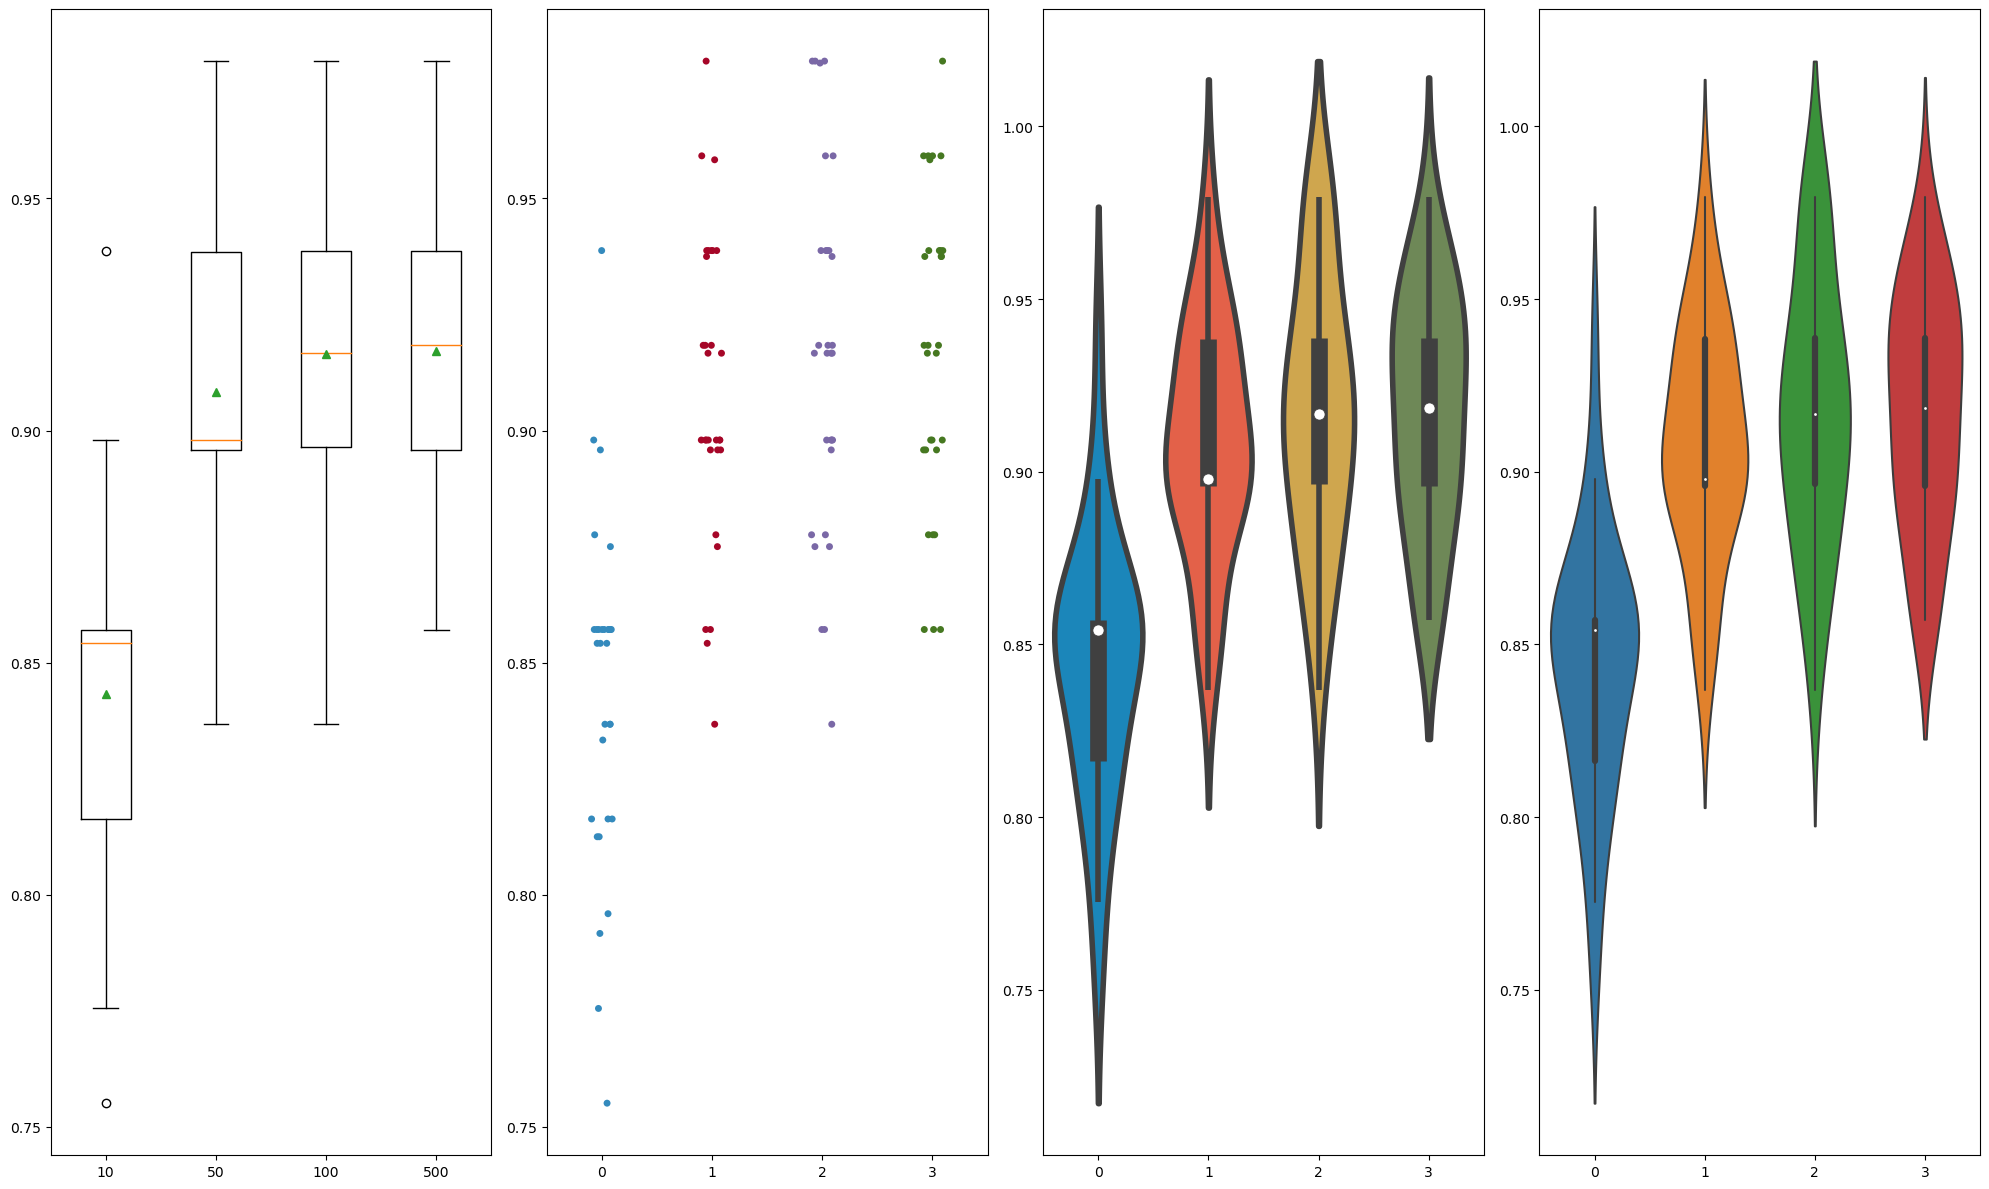

In [27]:
""" Evaluate 1 """
hyper = 'tree'
create_and_show_model(hyper, X_val, y_val)

>0.1 0.776 (0.154)
>0.2 0.888 (0.039)
>0.3 0.905 (0.040)
>0.4 0.913 (0.037)
>0.5 0.919 (0.031)
>0.6 0.919 (0.035)
>0.7 0.928 (0.030)
>0.8 0.926 (0.034)
>0.9 0.921 (0.030)
>1.0 0.912 (0.035)


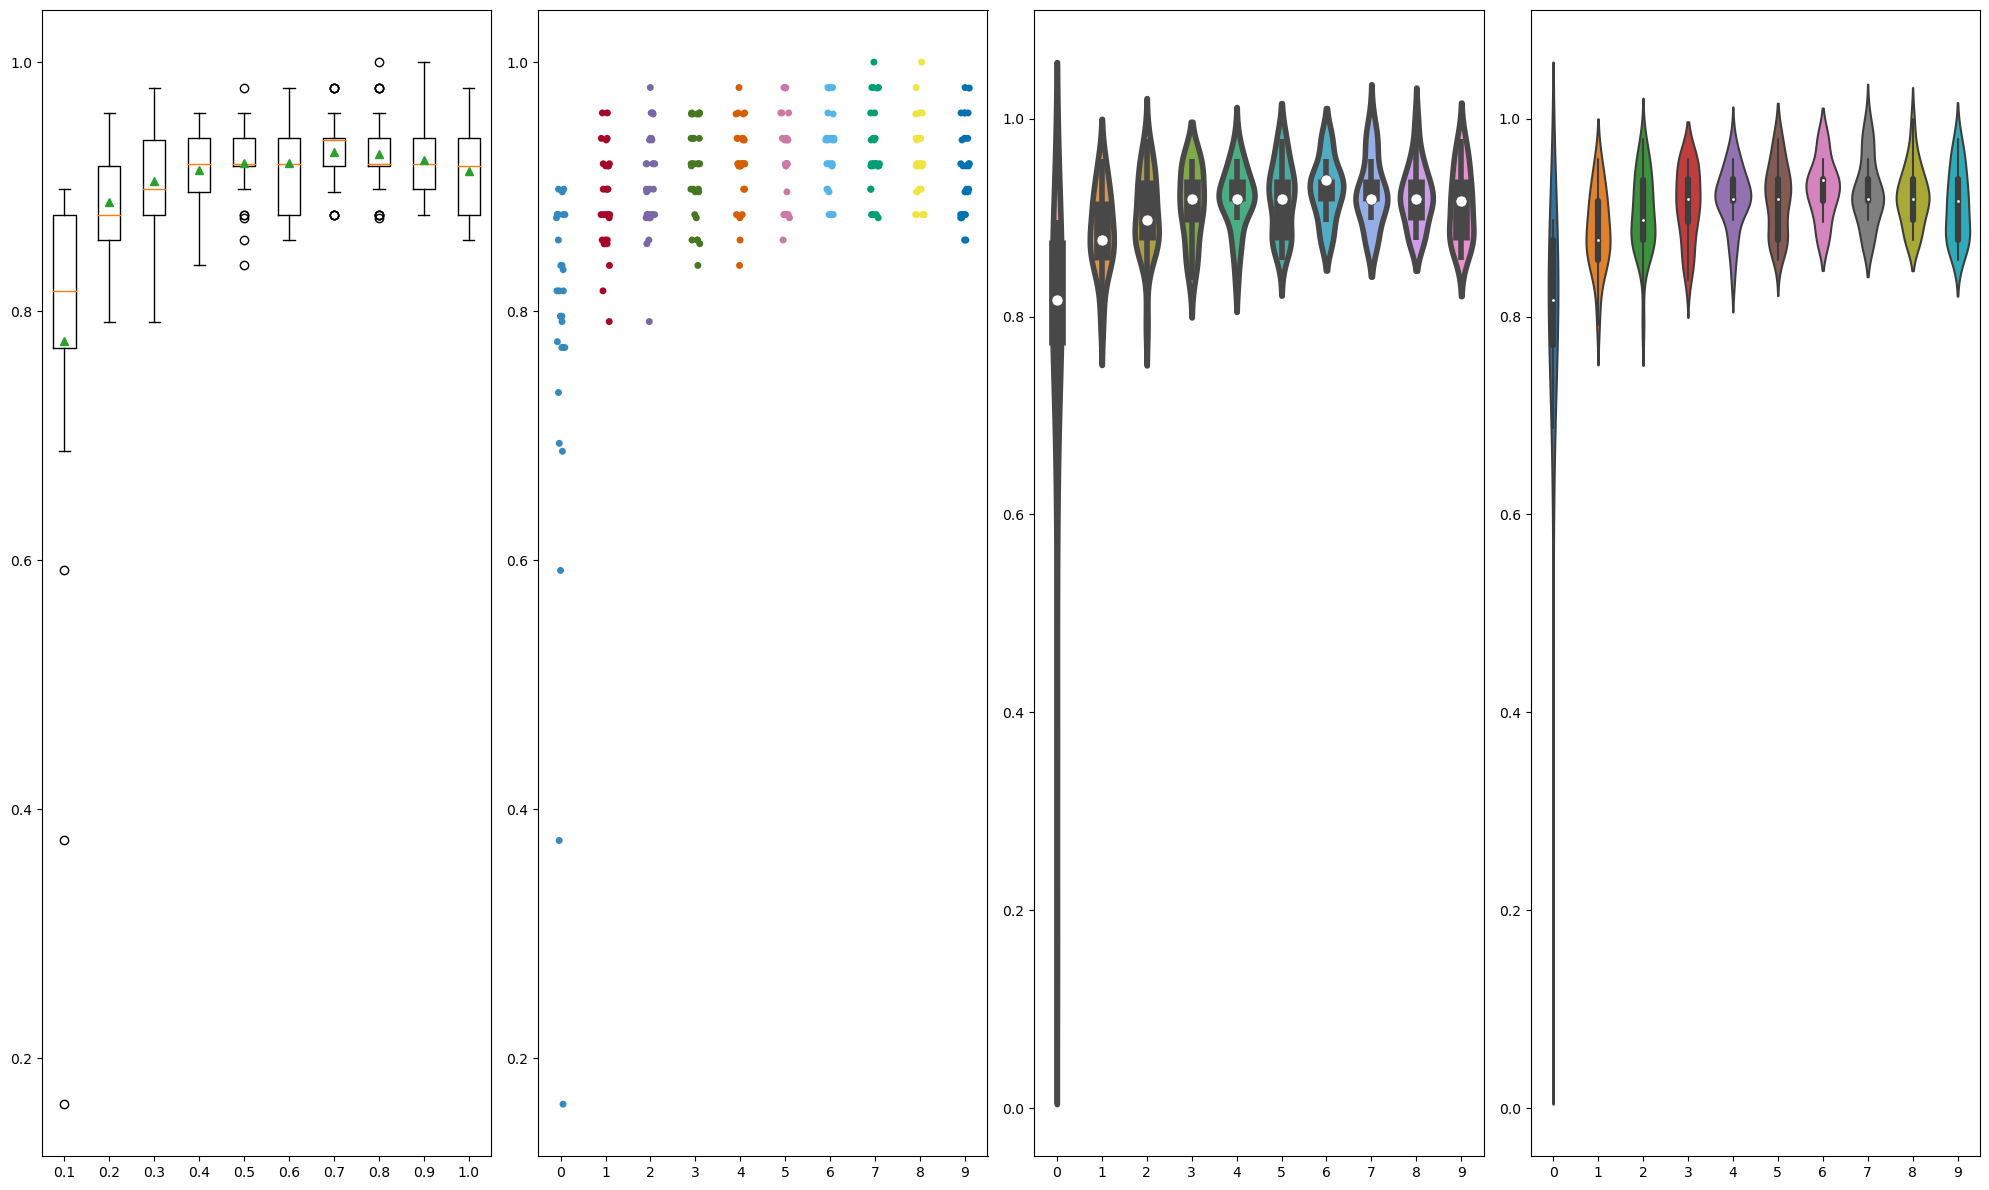

In [28]:
""" Evaluate 2 """
hyper = 'sample'
create_and_show_model(hyper, X_val, y_val)

>1 0.933 (0.032)
>2 0.948 (0.024)
>3 0.951 (0.025)
>4 0.948 (0.031)


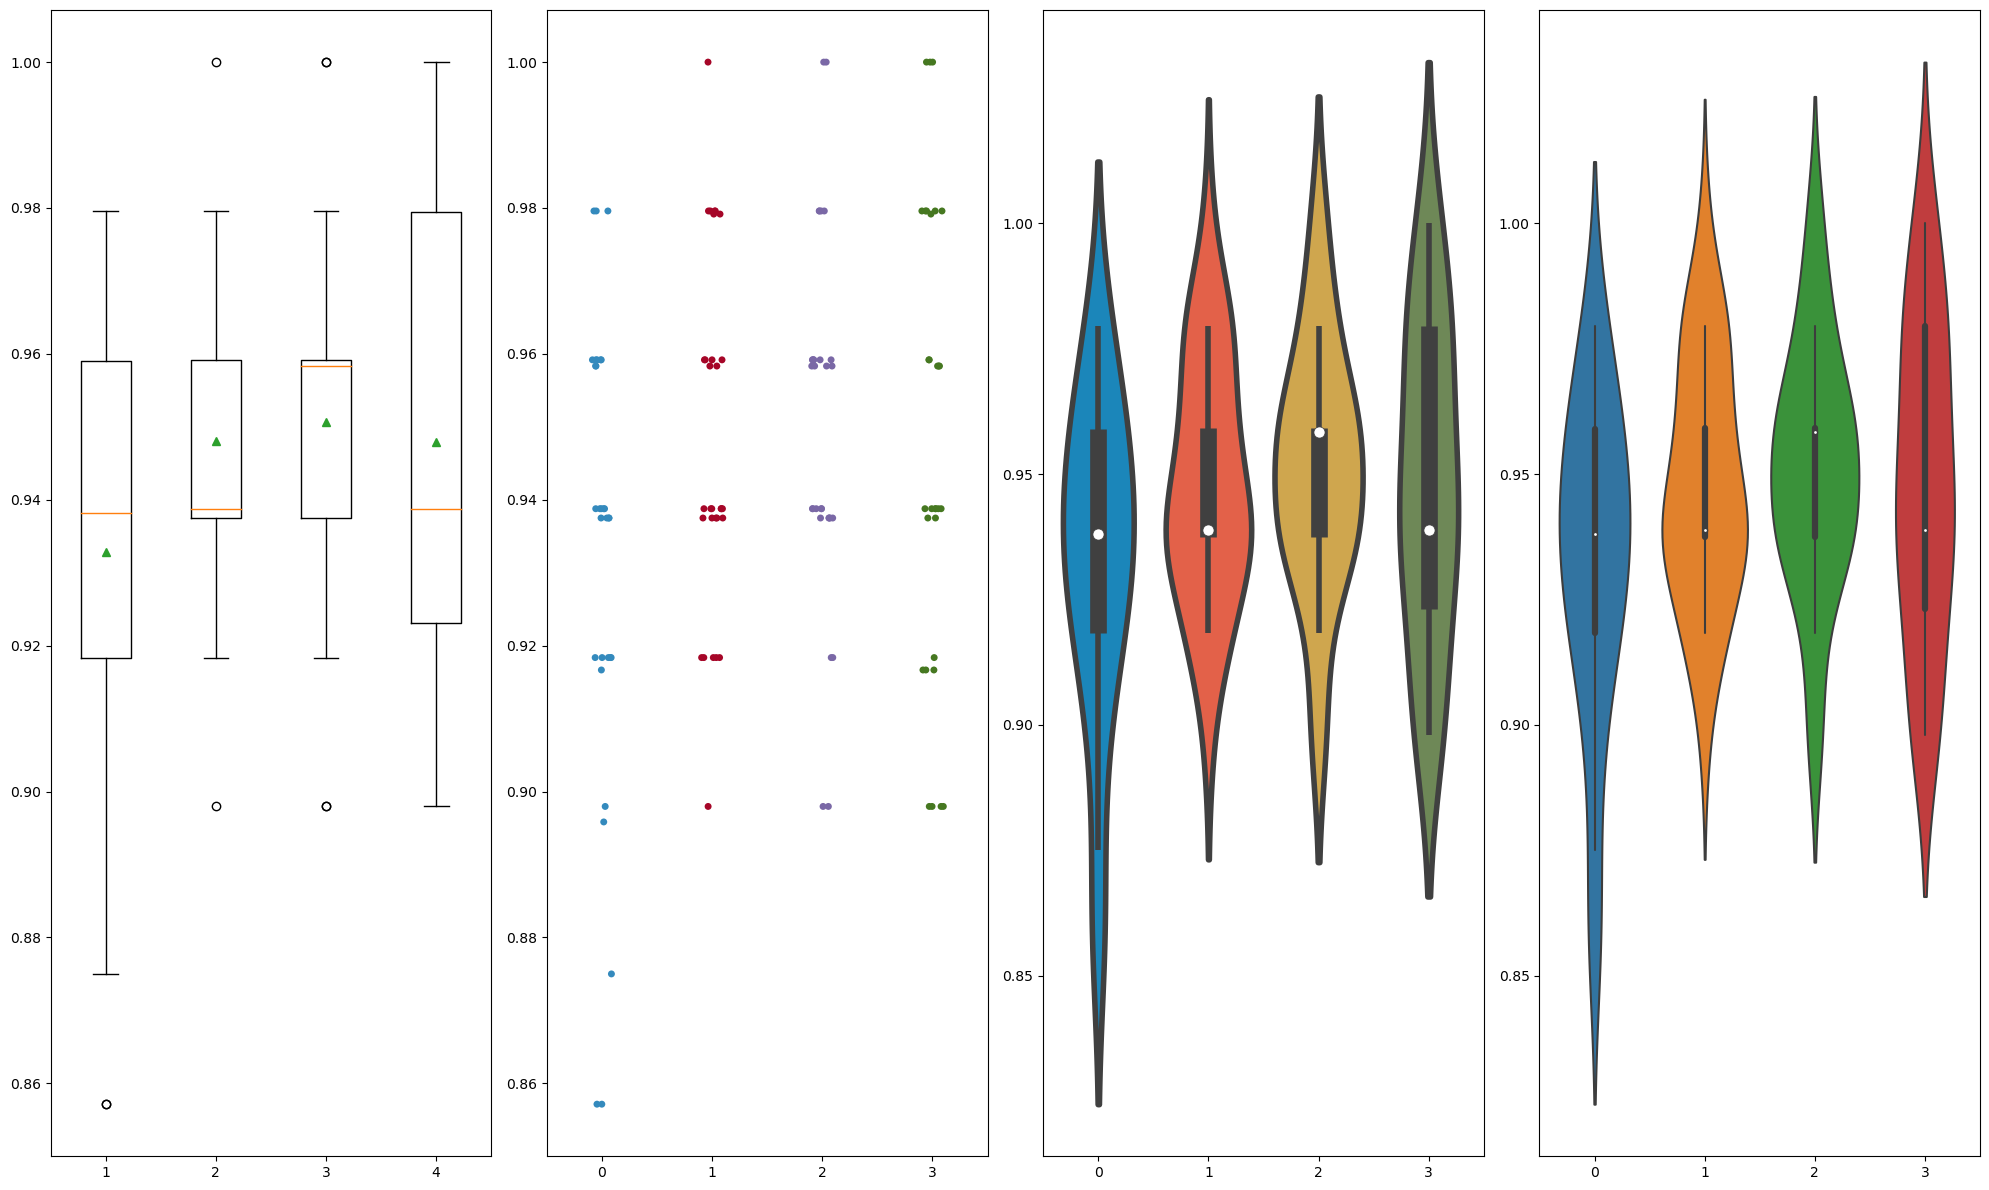

In [29]:
""" Evaluate 3 """
hyper = 'feature'
create_and_show_model(hyper, X_val, y_val)

>0.0001 0.164 (0.002)
>0.0010 0.676 (0.041)
>0.0100 0.837 (0.044)
>0.1000 0.912 (0.037)
>1.0000 0.880 (0.040)


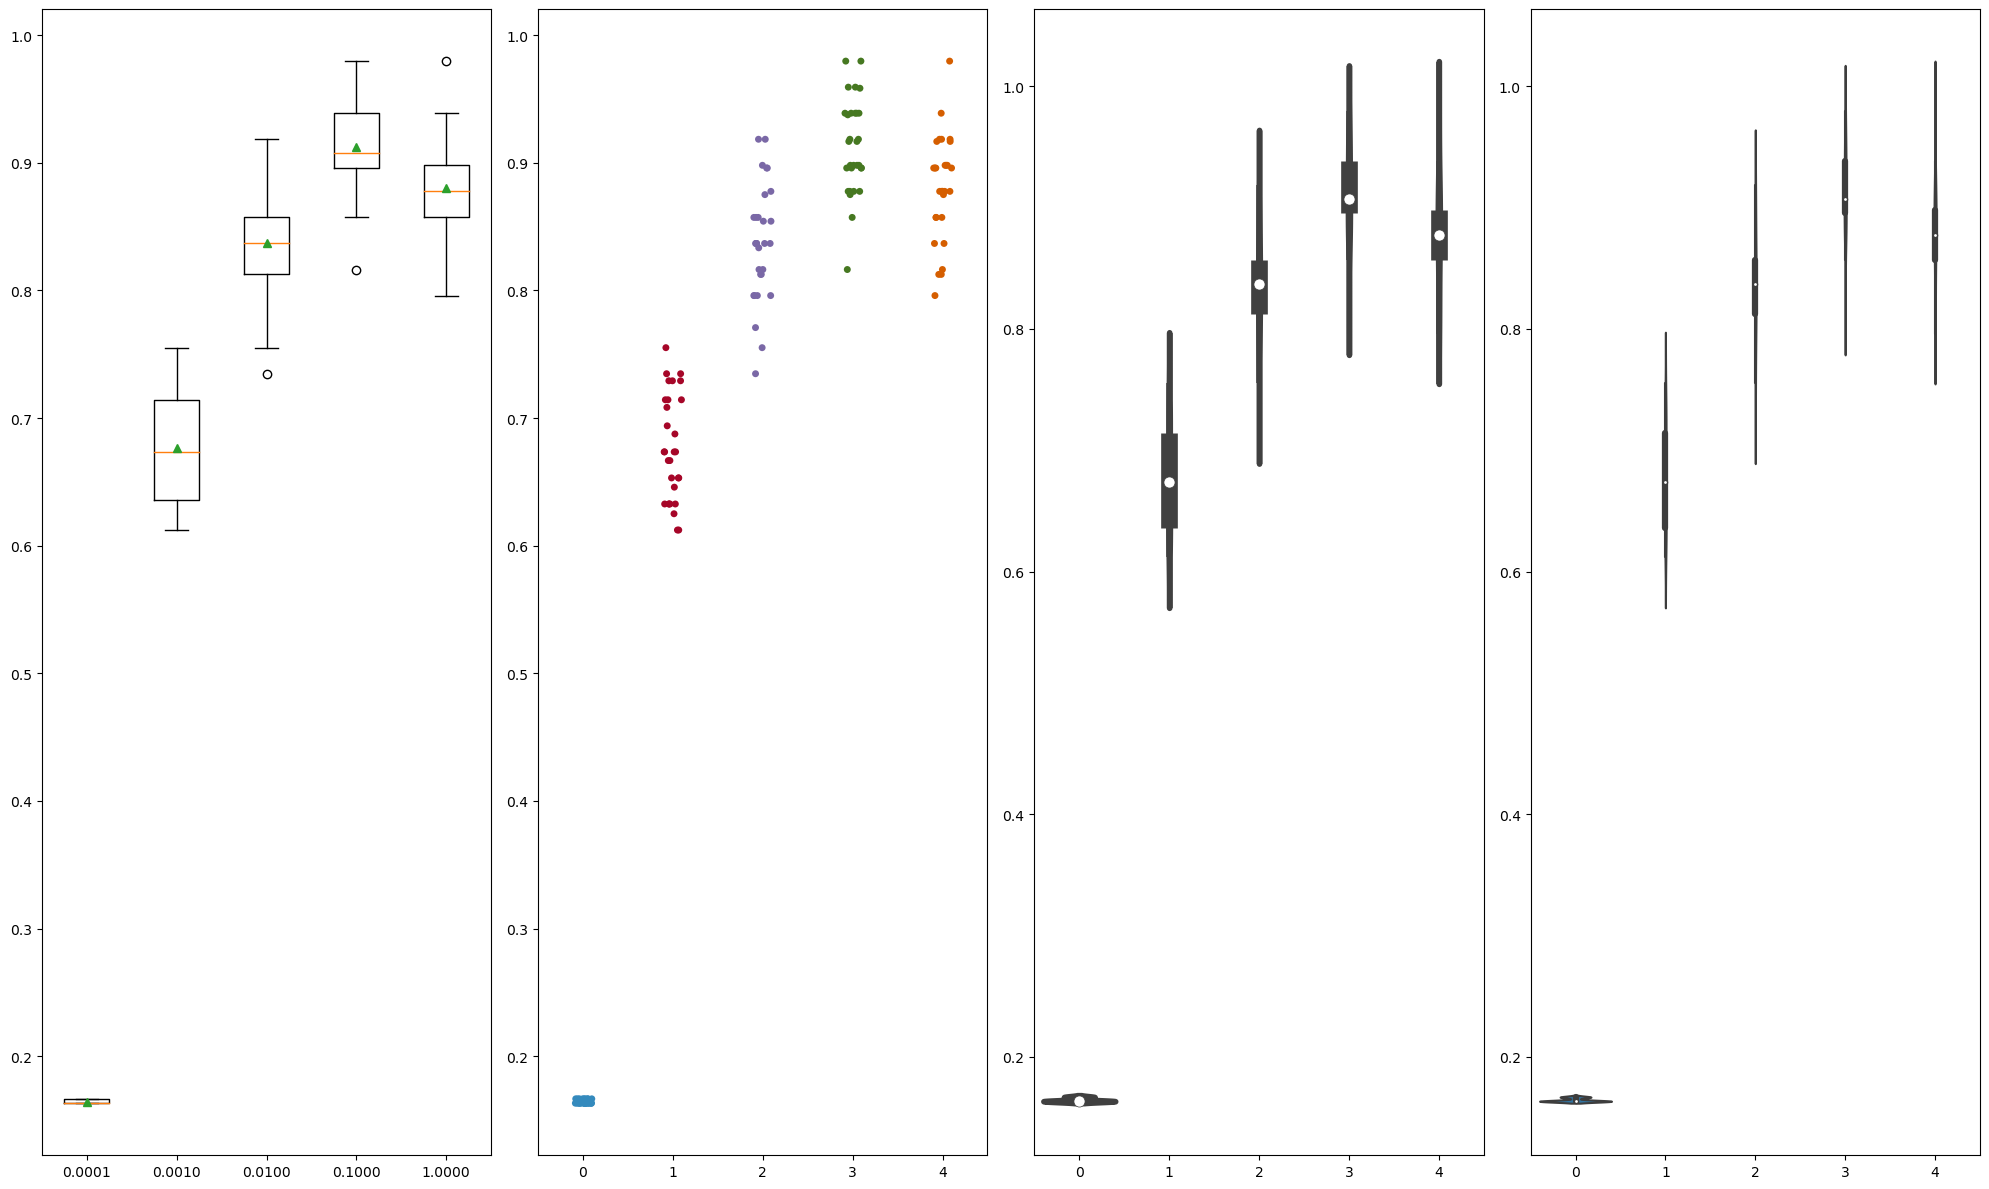

In [30]:
""" Evaluate 4 """
hyper = 'rate'
create_and_show_model(hyper, X_val, y_val)

>1 0.886 (0.032)
>2 0.901 (0.038)
>3 0.916 (0.034)
>4 0.908 (0.033)
>5 0.883 (0.043)
>6 0.828 (0.048)
>7 0.820 (0.052)
>8 0.807 (0.051)
>9 0.813 (0.051)
>10 0.821 (0.047)


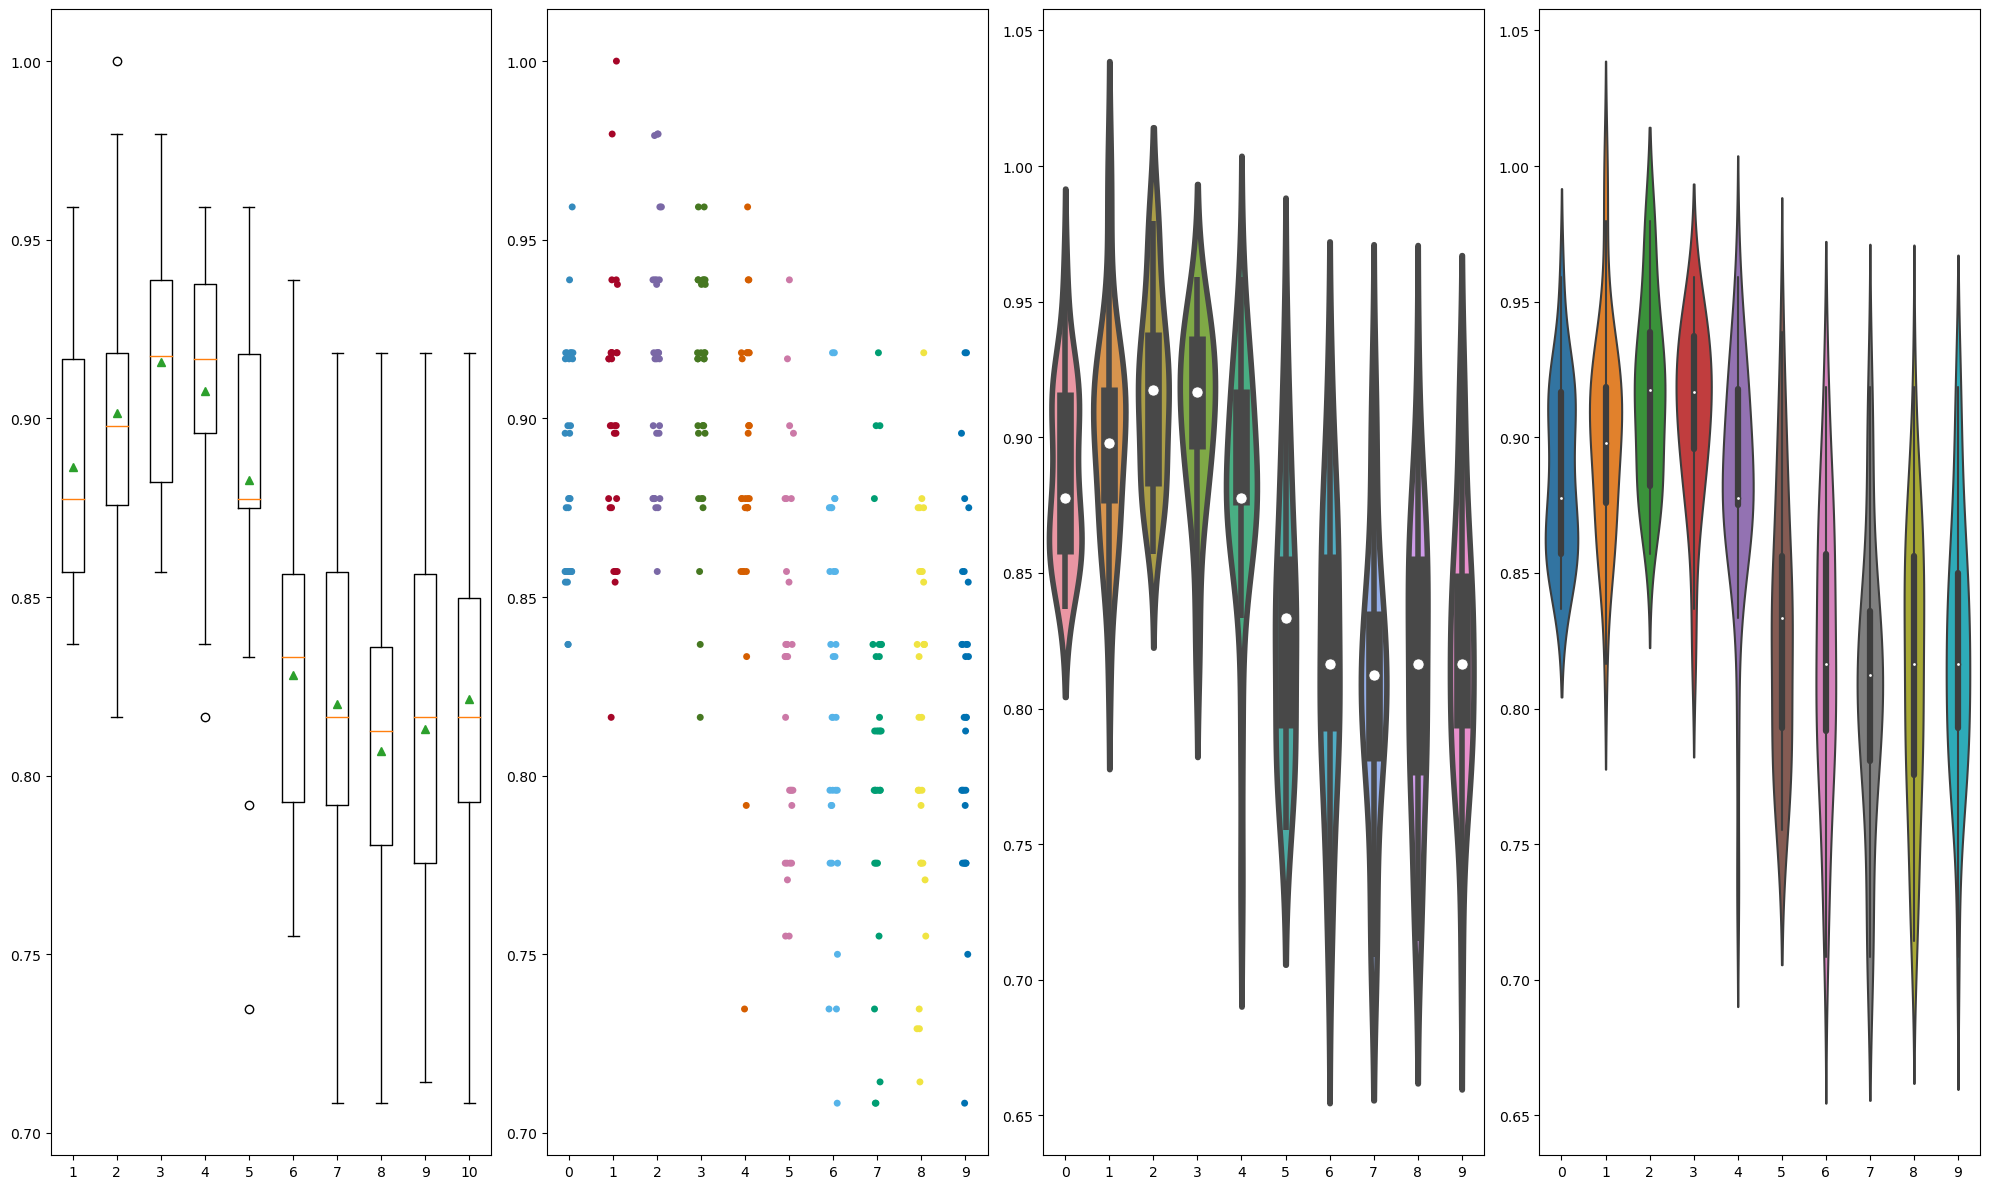

In [31]:
""" Evaluate 5 """
hyper = 'depth'
create_and_show_model(hyper, X_val, y_val)

<div style="line-height:0.55">
<h2 style="color:#F46233  "> 5) Logistic Regression </h2>
</div>

- Cross-entropy loss is used here since the 'multi_class' option is set to 'multinomial'.  <br>
This loss penalizes the model more for making confident, incorrect predictions than for making uncertain, incorrect predictions. 

   $ L(y, yhat) = -sum(y * log(yhat)) $

- Solvers for mulinomial class = 'lbfgs', 'sag', 'saga' and 'newton-cg'. <br>
    Don't use the lbfgs method => "Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm" that stores only a few vectors, <br>
    that represent the gradients approximation implicitly.

In [32]:
""" Logit classifier """
logreg = LogisticRegression(C=1e4, solver='saga', max_iter=100000, multi_class='multinomial')
logreg.fit(X_train, y_train);   #; to avoid to show the classificator as output

In [33]:
y_val[0:30]

array([7, 4, 3, 4, 5, 5, 2, 5, 7, 0, 7, 1, 2, 0, 4, 7, 5, 0, 0, 5, 2, 1,
       4, 0, 2, 1, 3, 7, 4, 1])

In [34]:
# Predict on partial set
y_pred_val_log = logreg.predict(X_val)

In [35]:
##### Metrics
accuracy = metrics.accuracy_score(y_val, y_pred_val_log)
precision = metrics.precision_score(y_val, y_pred_val_log, average='weighted')
recall = metrics.recall_score(y_val, y_pred_val_log, average='weighted')
f1 = metrics.f1_score(y_val, y_pred_val_log, average='weighted')
roc_auc = metrics.roc_auc_score(y_val, logreg.predict_proba(X_val), multi_class='ovr')

print(f'Accuracy is: {accuracy:.3f}')
print(f'Precision is: {precision:.3f}')
print(f'Recall is: {recall:.3f}')
print(f'F1 score is: {f1:.3f}')
print(f'ROC AUC score is: {roc_auc:.3f}')

Accuracy is: 0.932
Precision is: 0.934
Recall is: 0.932
F1 score is: 0.932
ROC AUC score is: 0.989
